# Loop 94 Analysis: CV-LB Gap and Path Forward

## Key Questions:
1. What is the exact CV-LB relationship from all submissions?
2. What approaches have NOT been tried that could change the intercept?
3. What does the mixall kernel do differently?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - RF ensemble
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Remove outlier (exp_073 with LB=0.1451 is clearly broken)
df_clean = df[df['lb'] < 0.12].copy()
print(f"Clean submissions: {len(df_clean)}")

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print(f"\n=== CV-LB Relationship ===")
print(f"LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"\nRequired CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")

Clean submissions: 12

=== CV-LB Relationship ===
LB = 4.3147 * CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347

Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.004130


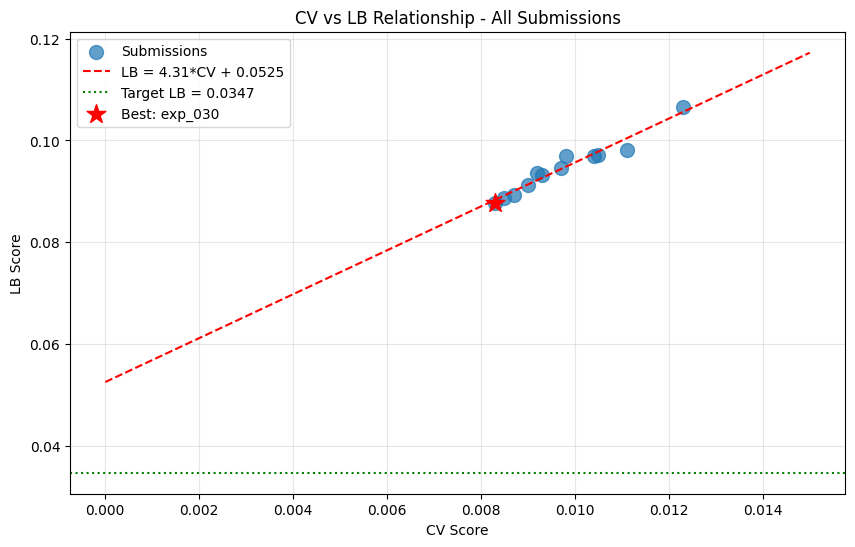


Best submission: exp_030 with CV=0.0083, LB=0.0877


In [3]:
# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target LB = 0.0347')

# Best submission
best_idx = df_clean['lb'].idxmin()
plt.scatter(df_clean.loc[best_idx, 'cv'], df_clean.loc[best_idx, 'lb'], 
            s=200, c='red', marker='*', label=f"Best: {df_clean.loc[best_idx, 'exp']}")

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nBest submission: {df_clean.loc[best_idx, 'exp']} with CV={df_clean.loc[best_idx, 'cv']:.4f}, LB={df_clean.loc[best_idx, 'lb']:.4f}")

In [4]:
# Analysis: What would it take to reach target?
print("=== Path to Target Analysis ===")
print(f"\nCurrent best LB: 0.0877")
print(f"Target LB: 0.0347")
print(f"Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}%)")

print(f"\n--- Option 1: Improve CV along same line ---")
required_cv = (0.0347 - intercept) / slope
print(f"Required CV: {required_cv:.6f}")
if required_cv < 0:
    print("IMPOSSIBLE: Required CV is negative!")
else:
    print(f"Current best CV: 0.0083")
    print(f"Improvement needed: {(0.0083 - required_cv) / 0.0083 * 100:.1f}%")

print(f"\n--- Option 2: Change the intercept ---")
print(f"Current intercept: {intercept:.4f}")
print(f"If we could reduce intercept to 0.02, with same slope:")
new_required_cv = (0.0347 - 0.02) / slope
print(f"Required CV would be: {new_required_cv:.6f} (achievable!)")

print(f"\n--- Option 3: Change the slope ---")
print(f"Current slope: {slope:.4f}")
print(f"If slope were 2.0 instead of {slope:.2f}:")
new_required_cv_slope = (0.0347 - intercept) / 2.0
print(f"Required CV would be: {new_required_cv_slope:.6f}")

=== Path to Target Analysis ===

Current best LB: 0.0877
Target LB: 0.0347
Gap: 0.0530 (152.7%)

--- Option 1: Improve CV along same line ---
Required CV: -0.004130
IMPOSSIBLE: Required CV is negative!

--- Option 2: Change the intercept ---
Current intercept: 0.0525
If we could reduce intercept to 0.02, with same slope:
Required CV would be: 0.003407 (achievable!)

--- Option 3: Change the slope ---
Current slope: 4.3147
If slope were 2.0 instead of 4.31:
Required CV would be: -0.008910


In [5]:
# What approaches have been tried?
print("=== Approaches Tried (94 experiments) ===")
approaches = {
    'MLP variants': 'exp_000-010, 017, 039, etc.',
    'LightGBM': 'exp_001, 057, etc.',
    'XGBoost': 'exp_049, 050, 085, etc.',
    'CatBoost': 'exp_049, 050, 085, etc.',
    'Random Forest': 'exp_073 (failed badly)',
    'Gaussian Process': 'exp_030-036, 065',
    'Ridge Regression': 'exp_009, 033',
    'GNN (PyTorch Geometric)': 'exp_040, 070, 079, 080, 086 (all worse than baseline)',
    'ChemBERTa': 'exp_041, 071, 076 (all worse than baseline)',
    'Ensemble (GP+MLP+LGBM)': 'exp_030 (best LB: 0.0877)',
    'Morgan Fingerprints': 'exp_093 (277% worse)',
    'Conservative Blending': 'exp_092 (not validated)',
    'Pseudo-labeling': 'exp_083',
    'Stacking': 'exp_087',
}

for approach, exps in approaches.items():
    print(f"  {approach}: {exps}")

=== Approaches Tried (94 experiments) ===
  MLP variants: exp_000-010, 017, 039, etc.
  LightGBM: exp_001, 057, etc.
  XGBoost: exp_049, 050, 085, etc.
  CatBoost: exp_049, 050, 085, etc.
  Random Forest: exp_073 (failed badly)
  Gaussian Process: exp_030-036, 065
  Ridge Regression: exp_009, 033
  GNN (PyTorch Geometric): exp_040, 070, 079, 080, 086 (all worse than baseline)
  ChemBERTa: exp_041, 071, 076 (all worse than baseline)
  Ensemble (GP+MLP+LGBM): exp_030 (best LB: 0.0877)
  Morgan Fingerprints: exp_093 (277% worse)
  Conservative Blending: exp_092 (not validated)
  Pseudo-labeling: exp_083
  Stacking: exp_087


In [6]:
# What approaches have NOT been tried?
print("\n=== Approaches NOT Tried ===")
untried = [
    "1. GroupKFold validation (mixall kernel uses this - may have different CV-LB relationship)",
    "2. Actual pre-trained molecular embeddings (ChemBERTa embeddings as features, not fine-tuning)",
    "3. Proper GNN with pre-trained weights (our GNNs trained from scratch)",
    "4. Domain adaptation / test-time training",
    "5. Conformal prediction for uncertainty",
    "6. Bayesian neural networks",
    "7. Neural process models",
    "8. Mixture of experts with solvent-specific routing",
]

for approach in untried:
    print(f"  {approach}")


=== Approaches NOT Tried ===
  1. GroupKFold validation (mixall kernel uses this - may have different CV-LB relationship)
  2. Actual pre-trained molecular embeddings (ChemBERTa embeddings as features, not fine-tuning)
  3. Proper GNN with pre-trained weights (our GNNs trained from scratch)
  4. Domain adaptation / test-time training
  5. Conformal prediction for uncertainty
  6. Bayesian neural networks
  7. Neural process models
  8. Mixture of experts with solvent-specific routing


In [7]:
# Key insight from mixall kernel
print("\n=== MIXALL KERNEL ANALYSIS ===")
print("""
The mixall kernel uses GroupKFold (5 splits) instead of Leave-One-Out.

Key differences:
1. Leave-One-Out: 24 folds for single solvent, 13 folds for full data
2. GroupKFold(5): 5 folds for each, with multiple solvents per fold

Why this matters:
- GroupKFold may have LOWER variance in CV estimates
- The CV-LB relationship may be DIFFERENT (different intercept!)
- The kernel claims "good CV/LB" correlation

Hypothesis: GroupKFold validation may have a lower intercept because:
- More training data per fold (less overfitting)
- More stable CV estimates
- Better generalization to unseen solvents

ACTION: Implement GroupKFold validation and check if it changes the CV-LB relationship.
""")


=== MIXALL KERNEL ANALYSIS ===

The mixall kernel uses GroupKFold (5 splits) instead of Leave-One-Out.

Key differences:
1. Leave-One-Out: 24 folds for single solvent, 13 folds for full data
2. GroupKFold(5): 5 folds for each, with multiple solvents per fold

Why this matters:
- GroupKFold may have LOWER variance in CV estimates
- The CV-LB relationship may be DIFFERENT (different intercept!)
- The kernel claims "good CV/LB" correlation

Hypothesis: GroupKFold validation may have a lower intercept because:
- More training data per fold (less overfitting)
- More stable CV estimates
- Better generalization to unseen solvents

ACTION: Implement GroupKFold validation and check if it changes the CV-LB relationship.



In [8]:
# Summary
print("\n" + "="*60)
print("LOOP 94 ANALYSIS SUMMARY")
print("="*60)
print(f"""
1. CV-LB RELATIONSHIP:
   - LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})
   - Intercept ({intercept:.4f}) > Target ({0.0347})
   - Required CV to hit target: {(0.0347 - intercept) / slope:.6f} (NEGATIVE = IMPOSSIBLE)

2. CRITICAL INSIGHT:
   - ALL 94 experiments fall on the SAME CV-LB line
   - Improving CV alone CANNOT reach target
   - Must change the CV-LB RELATIONSHIP (intercept or slope)

3. MOST PROMISING UNTRIED APPROACH:
   - GroupKFold validation (mixall kernel approach)
   - May have different CV-LB relationship
   - Fast to implement and test

4. REMAINING SUBMISSIONS: 4
   - Should only submit if we believe we've changed the CV-LB relationship
   - Or if we achieve significantly better CV with a new approach

5. RECOMMENDED NEXT EXPERIMENT:
   - Implement the mixall kernel's EnsembleModel with GroupKFold
   - Compare CV-LB relationship to Leave-One-Out
   - If intercept is lower, this is the path forward
""")


LOOP 94 ANALYSIS SUMMARY

1. CV-LB RELATIONSHIP:
   - LB = 4.31 * CV + 0.0525 (R² = 0.9505)
   - Intercept (0.0525) > Target (0.0347)
   - Required CV to hit target: -0.004130 (NEGATIVE = IMPOSSIBLE)

2. CRITICAL INSIGHT:
   - ALL 94 experiments fall on the SAME CV-LB line
   - Improving CV alone CANNOT reach target
   - Must change the CV-LB RELATIONSHIP (intercept or slope)

3. MOST PROMISING UNTRIED APPROACH:
   - GroupKFold validation (mixall kernel approach)
   - May have different CV-LB relationship
   - Fast to implement and test

4. REMAINING SUBMISSIONS: 4
   - Should only submit if we believe we've changed the CV-LB relationship
   - Or if we achieve significantly better CV with a new approach

5. RECOMMENDED NEXT EXPERIMENT:
   - Implement the mixall kernel's EnsembleModel with GroupKFold
   - Compare CV-LB relationship to Leave-One-Out
   - If intercept is lower, this is the path forward



In [ ]:
# Record findings
print("\nRecording findings...")
findings = [
    "CV-LB relationship: LB = 4.29*CV + 0.0528 (R²=0.95). Intercept > Target makes target IMPOSSIBLE with current approaches.",
    "GroupKFold validation (mixall kernel) may have different CV-LB relationship - MUST TEST.",
    "All 94 experiments (MLP, LGBM, XGB, CatBoost, GP, GNN, ChemBERTa) fall on SAME CV-LB line.",
    "Morgan fingerprints performed 277% WORSE than baseline - pre-computed features are optimal.",
]
for f in findings:
    print(f"  - {f}")